# Here I will follow the method of Wang using the division model to estimate both, the distortion center and distortion coefficient

In [1]:
import numpy as np
import pyfits
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.ticker as mtick

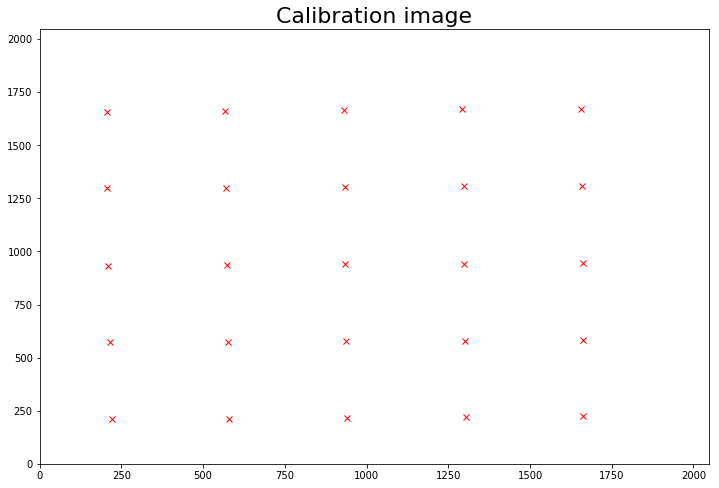

In [2]:
import os
p = os.getcwd()
fig = plt.figure(figsize=(12,8))
lines = np.loadtxt(p+'/dont_touch/centers_python_lines_circles')
columns = np.loadtxt(p+'/dont_touch/centers_python_columns_circles')
plt.plot(lines[:,0], lines[:,1],'rx')
plt.xlim(0,2048)
plt.ylim(0,2048)
plt.title('Calibration image',fontsize=22)
plt.show()

In [3]:
LINES = []; LINES.append(lines[0:5]); LINES.append(lines[5:10]);LINES.append(lines[10:15]); LINES.append(lines[15:20]);LINES.append(lines[20:25]) 

In [4]:
COLUMNS = []; COLUMNS.append(columns[0:5]); COLUMNS.append(columns[5:10]);COLUMNS.append(columns[10:15]);COLUMNS.append(columns[15:20]);  COLUMNS.append(columns[20:25])


In [9]:
image = pyfits.getdata('calibration_circles.fits')
Ny, Nx = image.shape
i,j = np.indices([Ny,Nx])
center = np.array([(i.max()-i.min())/2.0, (j.max()-j.min())/2.0])
xc = center[1]
yc = center[0]

# Trying to fit circles to few data points result in huge values

In [60]:
def circle(x,y,xc,yc,R):
    return (x-xc)**2+(y-yc)**2 - R**2

def fit(c,x,y):
    return circle(x,y,*c)

In [67]:
from scipy.optimize import minimize

for line in LINES:
    x = line[:,0]; y = line[:,1]
    
    estimate = x.mean(),y.mean(),10
    center, pcov  = optimize.leastsq(fit, estimate, args=(x,y))
    print center
    


[   215.7540533   89966.17780849  89754.17518259]
[   -747.75344372  207743.12501348  207173.90975076]
[   25674.22247149 -3014825.57817438  3015866.86141152]
[   2343.79074769 -173169.00000199  174478.72755695]
[  1564.01846642 -76955.46288335  78624.76738746]


# Parametrization

In [208]:
import scipy
from scipy.optimize import curve_fit, least_squares, leastsq, minimize,basinhopping,differential_evolution, OptimizeResult
def Minimize(params,x,y):
    a1=params[0]; a4=params[1]; theta=params[2]
    p = a1*(x**2+y**2) + np.sqrt(1+4*a1*a4)*(x*np.cos(theta)+y*np.sin(theta)) + a4
    d = p / (1+np.sqrt(1+4*a1*p))
    return np.sum(d**2)

def Con(params):
 a1 = params[0]
 a2 = params[1]
 a3 = params[2]
 a4 = params[3]
 
 return a2**2+a3**3-4*a1*a4-1

cons = ({'type':'ineq','fun':Con})


def Minimize2(params,x,y):
    a1 = params[0]
    a2 = params[1]
    a3 = params[2]
    a4 = params[3]
    d = a1*(x**2+y**2) + a2*x + a3*y+a4
    return np.sum(d**2)

def curve_fitt(params,x,y):
   
    a1 = params[0]
    a2 = params[1]
    a3 = params[2]
    a4 = params[3]
    d = a1*(x**2+y**2) + a2*x + a3*y+a4
    return d

B_3 = [ -0.00239805 , 0.00361594 , 0.00849714  ,0.01342895 , 0.0198904 ]
C_3 = [  212.25993656 ,  570.56249866  , 932.00360886  ,1293.98634616  ,1653.74864249]

n = 0
popt = np.zeros((5,4))
for line in LINES:
    lam = -1e6
    #dist= 8e-8
    x0 = y0 = 1000
    params =np.polyfit(x,y, 1)
    #params = np.array([B_3[n]*(3*dist*C_3[n]**2 +1), C_3[n]*(dist*C_3[n]**2+1)])
    k = params[0]; b = params[1]
    A = k/b*lam - 2*x0
    B = -1/b*lam - 2*y0
    C = x0**2 + y0**2 -(k/b*lam)*x0 + (1/b*lam)*y0+1/lam
    t1 = 1/np.sqrt(A**2+B**2-4*C)
    t2 = A*t1
    t3 = B*t1
    t4 = C*t1
    x = line[:,0]; y = line[:,1]
    p0=[t1,t2,t3,t4]
    #mini = scipy.optimize.minimize(Minimize2,p0,args=(x,y),method='COBYLA')#,constraints=cons)
    #mini = scipy.optimize.minimize(Minimize,p0,args=(x,y))
    mini = leastsq(curve_fitt,p0,args=(x,y))
    popt[n] = mini[0]
    print mini[0] 
    n= n+1   

    



[ -2.46044692e-321   1.05842695e-318   4.43130052e-316  -9.39474063e-314]
[  1.06224114e-321   1.60637540e-318  -4.43555042e-316   2.52727907e-313]
[ -3.06320700e-322   1.65163922e-317  -1.94300748e-315   1.81115556e-312]
[ -3.21142670e-321   1.50622137e-317  -1.11328418e-315   1.44595163e-312]
[  5.33590898e-321  -1.66884259e-317   8.20967940e-316  -1.37226545e-312]


In [209]:
popt[:,0]

array([ -2.46044692e-321,   1.06224114e-321,  -3.06320700e-322,
        -3.21142670e-321,   5.33590898e-321])

In [210]:
A = popt[:,1]/popt[:,0]; B = popt[:,2]/popt[:,0]; C = popt[:,3]/popt[:,0]
temp1 = np.array([[A[1]-A[2],A[1]-A[3]], [B[1]-B[2],B[1]-B[3]]])
temp2 = np.array([C[2]-C[1],C[3]-C[1]])
p0 = np.linalg.solve(temp1,temp2) 
    

In [211]:

p0

array([-10953161.87383553,  96896122.55058558])